# Characterizing Rb Lab's Red Pitaya (STEMlab 125-14) for Spectrum Analysis
A Jupyter Notebook created by Josiah Sinclair

Rb lab has a Red Pitaya (STEMlab 125-14). Information about this model can be found on Red Pitaya's website: https://www.redpitaya.com/Catalog/p20/stemlab-125-14-starter-kit?cat=c105

The Red Pitaya can be used as a digital oscilloscope or digital spectrum analyzer. In this notebook, I will focus on characterizing the Red Pitaya as a spectrum analyzer. Relevant information about the spectrum analyzer is available here: https://www.redpitaya.com/f146/spectrum-analyzer/specifications


## The first set of tests I would like to run are tests on the input noise level

The specified input noise is < -119 dBm/Hz. Let's go ahead and see if this is true. 

To test this, I have terminated the input with 50 Ohms and measured the noise floor over different frequency ranges. 

In [2]:
# Import some useful modules
import numpy as np
import matplotlib as mpl
from matplotlib import pylab as plt

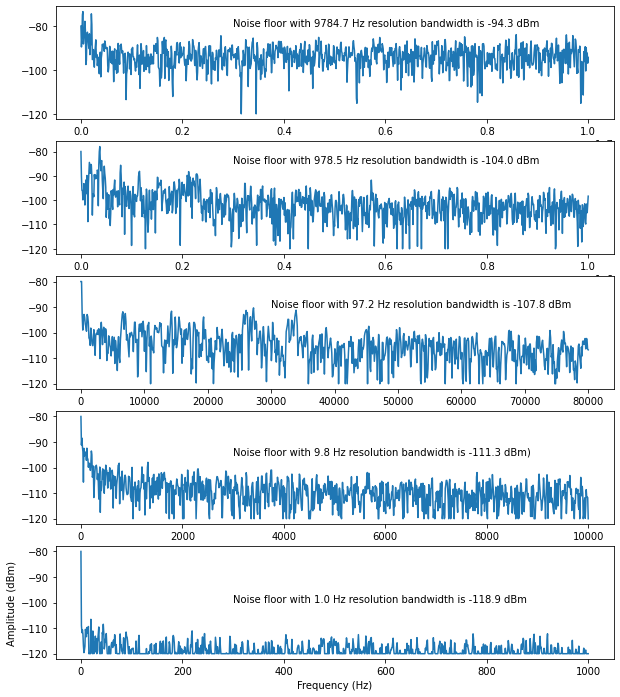

In [400]:
# Import data.
Background10000kHz = np.genfromtxt('Data/Background/1Mohm10000kHz.csv', delimiter=',')[1:-1] # Discard the first value as it is not a number
Background1000kHz = np.genfromtxt('Data/Background/1Mohm1000kHz.csv', delimiter=',')[1:-1]
Background100kHz = np.genfromtxt('Data/Background/1Mohm100kHz.csv', delimiter=',')[1:-200]
Background10kHz = np.genfromtxt('Data/Background/1Mohm10kHz.csv', delimiter=',')[1:-1]
Background1kHz = np.genfromtxt('Data/Background/1Mohm1kHz.csv', delimiter=',')[1:-1]

# Generate frequencies
f_10000kHz = np.linspace(0,1e7,len(Background10000kHz))
df_10000kHz = f_10000kHz[1]-f_10000kHz[0]
f_1000kHz = np.linspace(0,1e6,len(Background1000kHz))
df_1000kHz = f_1000kHz[1]-f_1000kHz[0]
f_100kHz = np.linspace(0,0.8e5,len(Background100kHz))
df_100kHz = f_100kHz[1]-f_100kHz[0]
f_10kHz = np.linspace(0,1e4,len(Background10kHz))
df_10kHz = f_10kHz[1]-f_10kHz[0]
f_1kHz = np.linspace(0,1e3,len(Background1kHz))
df_1kHz = f_1kHz[1]-f_1kHz[0]

# Alright, I would now like to exclude the bottom 50% of each measurement and find the average noise floor
length = len(Background10000kHz)
NoiseFloor_10000kHz = np.average(Background10000kHz[int(0.5*length):-1])
NoiseFloor_1000kHz = np.average(Background1000kHz[int(0.5*length):-1])
NoiseFloor_100kHz = np.average(Background100kHz[int(0.5*length):-1])
NoiseFloor_10kHz = np.average(Background10kHz[int(0.5*length):-1])
NoiseFloor_1kHz = np.average(Background1kHz[int(0.5*length):-1])

fig, ax = plt.subplots(5, figsize = [10,12])
ax[0].plot(f_10000kHz,Background10000kHz)
ax[0].text(3e6,-80, "Noise floor with %1.1f Hz resolution bandwidth is %1.1f dBm" %(df_10000kHz, NoiseFloor_10000kHz))
ax[1].plot(f_1000kHz,Background1000kHz)
ax[1].text(3e5,-85, "Noise floor with %1.1f Hz resolution bandwidth is %1.1f dBm" %(df_1000kHz, NoiseFloor_1000kHz))
ax[2].plot(f_100kHz,Background100kHz)
ax[2].text(3e4,-90, "Noise floor with %1.1f Hz resolution bandwidth is %1.1f dBm" %(df_100kHz, NoiseFloor_100kHz))
ax[3].plot(f_10kHz,Background10kHz)
ax[3].text(3e3,-95, "Noise floor with %1.1f Hz resolution bandwidth is %1.1f dBm)" %(df_10kHz, NoiseFloor_10kHz))
ax[4].plot(f_1kHz,Background1kHz)
ax[4].text(3e2,-100, "Noise floor with %1.1f Hz resolution bandwidth is %1.1f dBm" %(df_1kHz, NoiseFloor_1kHz))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dBm)")

plt.show()

Alright, so I guess I can agree that the noise floor is -119 dBm/Hz, as specified. Now I'd like to confirm that the y-scale is calibrated properly. 

# Checking the y-scale calibration by measuring the spectrum of a known input (and comparing to a second SA)

Next, I will measure the spectrum of a known input and compare it to a trusted spectrum analyzer, the Rigol DSA815 borrowed from Clock Lab. 
My signal will be a sinusoid with a frequency of 100 kHz, an amplitude of 100 mV (rms is 33 mV), and an offset of 0 mV produced by an Agilent 33250A. This function generator output has an impedance of 50 Ohm, so when I measure it on a scope I must terminate with 50 Ohm in order to measure a 100 mV pk-pk 100 kHz sine wave. 

The next step is to measure the spectrum with the Rigol SA. With the Rigol SA, I see a 100 kHz peak whose amplitude is
- 33 mV 
- 22 uW
- -16.5 dBm
So what are the conversions here? 

Well, the power in mW should be related to the power in dBm by the following formula

P[mW] = 10^(P[dBm]/10)

Let's check it. 

In [386]:
10**(-16.5/10)/1000

2.23872113856834e-05

Great. And the voltage can be related to the power using the following formula

P[W] = V^2/R, where R = 50 ohm. 

So let's check this now. 

In [387]:
np.sqrt(22e-6*50)

0.033166247903554

Great! Alright. Now let's test the Red Pitaya. Unplugging and sending the signal directly to the Red Pitaya, I measure a peak of -40.7 dBm at 100 kHz. Does this make sense? 

Well, first let's calculate the power (in Watts) and then the rms voltage (V)

In [388]:
Power = 10**(-40.7/10)/1000 #in Watts
Vrms = np.sqrt(Power*1e6)
print(Vrms)

0.2917427014001166


Yuck! That is way off, roughly by a factor of 8-9 (or by 64 in power if you prefer). 
Alright, I'm just going to roughly characterize how far off the Red Pitaya is as a function of frequency

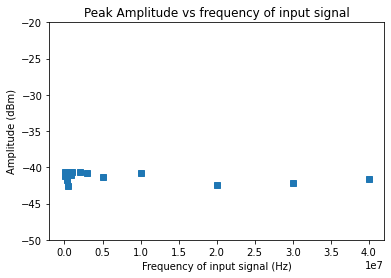

In [398]:
f0 = np.array([10e3,100e3,200e3,300e3,400e3,500e3,600e3,700e3,800e3,900e3,1e6,2e6,3e6,5e6,10e6,20e6,30e6,40e6])
Amp_dbm = np.array([-41.2, -40.7, -41.1, -41.8, -42.6, -41.1, -40.8, -40.7, -40.7, -41.1, -40.7, -40.7, -40.8, -41.3, -40.8, -42.4, -42.1, -41.6])
plt.figure()
plt.plot(f0, Amp_dbm, 's')
plt.title("Peak Amplitude vs frequency of input signal")
plt.ylim(-50,-20)
plt.ylabel("Amplitude (dBm)")
plt.xlabel("Frequency of input signal (Hz)")
plt.show()

Alright, it is clear that the Red Pitaya is roughly consistent in it's (incorrect) measurement of the amplitude for independent of what frequency is used. Now let's vary the amplitude and see what changes (and also compare to the Rigol SA and a Tektronix Oscilloscope in FFT mode)

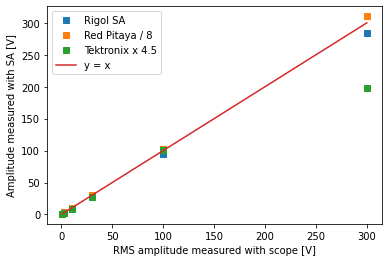

In [390]:
Signal_rms_amp = np.array([1,3, 10, 30, 100, 300])
Amp_dbm_Pitaya = np.array([-71.8, -62.3, -51.5, -42.1, -31.7, -22.1])
Amp_dbm_Rigol = np.array([-48, -38, -27.5, -17.9, -7.5, 2.1])
Amp_dbm_Tektronix = np.array([-62, -50.5, -40.9, -31.3, -20, -14.1])
Amp_V_Pitaya = 1000*np.sqrt(1e6*10**(Amp_dbm_Pitaya/10)/1000)
Amp_V_Rigol = 1000*np.sqrt(50*10**(Amp_dbm_Rigol/10)/1000)
Amp_V_Tektronix = 1000*np.sqrt(50*10**(Amp_dbm_Tektronix/10)/1000) # I was terminating with 50 ohm

plt.figure()
plt.plot(Signal_rms_amp, Amp_V_Rigol, 's' , label = 'Rigol SA')
plt.plot(Signal_rms_amp, Amp_V_Pitaya/8, 's', label = "Red Pitaya / 8")
plt.plot(Signal_rms_amp, 4.5*Amp_V_Tektronix, 's', label = "Tektronix x 4.5")

plt.plot(Signal_rms_amp, Signal_rms_amp, '-', label = "y = x" )
plt.legend()
plt.ylabel("Amplitude measured with SA [V]")
plt.xlabel("RMS amplitude measured with scope [V]")
plt.show()


In conclusion, the Rigol SA's y-scale is properly calibrated, but neither the Red Pitaya nor the Spectrum Analyzer's is. This isn't a big deal for the Red Pitaya, as the y-axis scale is off by a constant amount that is independent of input power and frequency. Just rescale the y-axis (in mW) down by a factor of 64 and you are good to go. The situation is a bit worse for the Tektronix FFT, which has to be rescaled by an amount that depends on the input power. Best to not use this for important spectrum measurements. 



As a final note, one way to think about what this means is that the Red Pitaya thinks it has a 1 MOhm resistor but actually it has a 16 kOhm resistor, and the Tektronix thinks it has a 1 MOhm resistor but it's actually more like 20 MOhm resistor (which also varies with input power). 

# Alright, now I will send in white noise lowpass filtered with 1 MHz. 

I'm sending in 100 mV rms white noise lowpass filtered with a Thorlabs 1 MHz lowpass to the Rigol SA. 
The spectrum displayed by the Rigol SA looks like the following: 
<img src = "Data/WhiteNoise100mVRMS1MHzLowpass.png" style="width:1000px;height:600px"/>


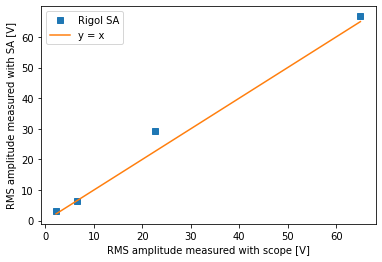

In [3]:
# Now, let's measure the value of the noise as a function of rms amplitude on the Rigol SA
V_rms = np.array([10,30,100,300]) #function generator setting
V_rms_meas = np.array([2.2, 6.51, 22.6, 65]) #Measured on the Tektronix oscilloscope with 50 Ohm before the 1 MHz lowpass filter

# Now let's measure the noise floor below 1 MHz
RBW = 1000
Rigol_dBmwithinRBW = np.array([-67, -61, -47.7, -40.5]) #this is now really dBm within a spectral slice of size RBW [dBm]

Rigol_VwithinRBW = 50*10**(Rigol_dBmwithinRBW/10)/1000 # So calculate V^2 within a spectral slice of size RBW [V^2]
Rigol_VsquaredperHz = Rigol_VwithinRBW/RBW # Calculate V^2/Hz
Rigol_mVperRTHz = 1000*np.sqrt(Rigol_VsquaredperHz)
Rigol_rms_mV = Rigol_mVperRTHz*np.sqrt(1e6) # Really one should just integrate the noise variance from f=0 to f=infinity, 
# but because it's white (flat) noise I can just multiply length x height.

plt.figure()
plt.plot(V_rms_meas,Rigol_rms_mV, 's', label = 'Rigol SA')
plt.plot(V_rms_meas, V_rms_meas, '-', label = 'y = x')
plt.ylabel("RMS amplitude measured with SA [V]")
plt.xlabel("RMS amplitude measured with scope [V]")
plt.legend()
plt.show()

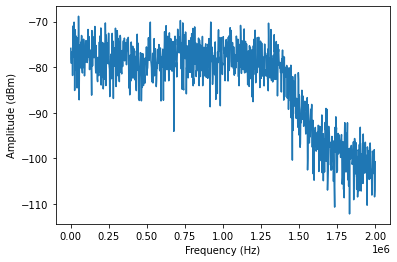

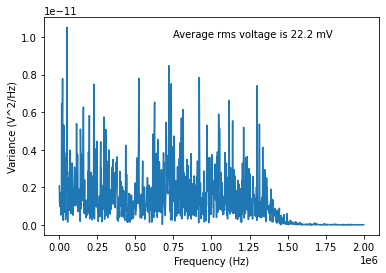

In [5]:
# Now, let's measure the value of the noise for 100 mV rms input noise on the Red Pitaya
# This corresponds to the third point in the previous measurement. 
RedPitaya_dbm = np.genfromtxt('Data/100mVrms2MHzband1MHzlowpass.csv', delimiter=',')[1:-1] # Discard the first value as it is not a number
# Generate frequencies
f_2MHz = np.linspace(0,2e6,len(RedPitaya_dbm))
df_2MHz = f_2MHz[1]-f_2MHz[0]
df_2MHz = df_2MHz/np.pi #Guess that this is the resolution bandwidth

plt.figure()
plt.plot(f_2MHz, RedPitaya_dbm)
plt.ylabel("Amplitude (dBm)")
plt.xlabel("Frequency (Hz)")


RedPitaya_VsquaredwithinRBW = 50*10**(RedPitaya_dbm/10)/1000 # So calculate V^2 within a spectral slice of size RBW [V^2]
RedPitaya_VsquaredperHz = RedPitaya_VsquaredwithinRBW/df_2MHz # Calculate V^2/Hz
RedPitaya_rms_mV = 1000*np.sqrt(np.sum(RedPitaya_VsquaredwithinRBW)*df_2MHz)

plt.figure()
plt.plot(f_2MHz,RedPitaya_VsquaredperHz)
plt.text(.75e6, 1e-11, "Average rms voltage is %1.1f mV" %(np.average(RedPitaya_rms_mV)))
plt.ylabel("Variance (V^2/Hz)")
plt.xlabel("Frequency (Hz)")
plt.show()


22.2 mV is quite quite close to the correct value of 22.6 mV. Nice! But notice that I only got the right answer when I used $df/\pi$ as my resolution bandwidth. 

Alright, so this all checks out, but what if I change the lowpass filter to 100 kHz? I don't want to change anything else. I guess I would expect the rms amplitude on the scope to decrease by about a factor of 3, but below 100 kHz I wouldn't expect the amplitude on the SA to change. 

And on the Rigol SA it does not. Nice. 

<img src = "Data/WhiteNoise100mVRMS100kHzLowpass.png" style="width:1000px;height:600px"/>



In [431]:
# Alright, well this makes sense. I am sending noise to the scope with 100 mV rms amplitude. 
# On the scope, I terminate with 50 ohm and then I pass through the 1 MHz lowpass filter, measuring 22 mV rms. 
# If I switch to a 100 kHz lowpass filter,  I measure an rms amplitude of 7-8 mV, which close to 22/sqrt(10). 
# On the Rigol SA, I measure about -48 dBm within a RBW of 1 kHz 
# On the Rigol SA, I can also measure about 0.75 mV within a sqrt(RBW) spectral slice (just convert dBm -> mV using a 50 ohm resistor). 
# To find the actual rms voltage, I should divide be sqrt(RBW) to get the noise per Hz, then I just multiply by the sqrt(bandwidth of 100 kHz)
print("RMS voltage is %1.1f mV as expected" %(0.75*np.sqrt(100e3/1000)))

RMS voltage is 7.5 mV as expected


Great, now let's do the Red Pitaya. 
First of all, I'm going to use a different frequency range (0-1 MHz) as well as the 100 kHz lowpass filter, to be good and sure I'm doing everything right. 

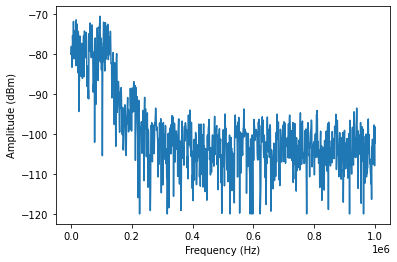

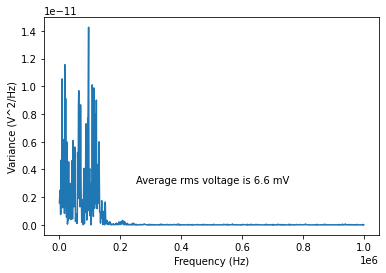

In [440]:
RedPitaya_dbm = np.genfromtxt('Data/100mVrms1MHzpassband100kHzlowpass.csv', delimiter=',')[1:-1] # Discard the first value as it is not a number
# Generate frequencies
f_1MHz = np.linspace(0,1e6,len(RedPitaya_dbm))
df_1MHz = f_1MHz[1]-f_1MHz[0]
df_1MHz = df_1MHz/np.pi

plt.figure()
plt.plot(f_1MHz, RedPitaya_dbm)
plt.ylabel("Amplitude (dBm)")
plt.xlabel("Frequency (Hz)")


RedPitaya_VsquaredwithinRBW = 50*10**(RedPitaya_dbm/10)/1000 # So calculate V^2 within a spectral slice of size RBW [V^2]
RedPitaya_VsquaredperHz = RedPitaya_VsquaredwithinRBW/df_1MHz # Calculate V^2/Hz
RedPitaya_rms_mV = 1000*np.sqrt(np.sum(RedPitaya_VsquaredwithinRBW)*df_1MHz)

plt.figure()
plt.plot(f_1MHz,RedPitaya_VsquaredperHz)
plt.text(.25e6, 3e-12, "Average rms voltage is %1.1f mV" %(np.average(RedPitaya_rms_mV)))
plt.ylabel("Variance (V^2/Hz)")
plt.xlabel("Frequency (Hz)")
plt.show()

Great, so 6.6 mV is very close to the 7-8 mV expected. Wonderful!

# Summary
In summary, it looks like we can use the Red Pitaya as a reliable spectrum analyzer as long as we use the correct y-scale calibration and resolution bandwidth. To correct the y-scale, convert dBm to mW and multiply be 1/64. The resolution bandwidth is $df/\pi$. 